In [1]:
from os.path import join as pjoin, isdir, basename, isfile
from os import listdir, mkdir
import numpy as np
from glob import glob
from tqdm import tqdm 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from scipy.signal import find_peaks

LEFT = 0.01
RIGHT = 0.02
FREQ=2000

In [2]:
def in_bin(pfc, st):
    return st >= pfc - LEFT and st <= pfc + RIGHT

def ordered(l):
    return all(l[i] <= l[i+1] for i in range(len(l) - 1))

def get_relative_times(pfc, str):
    results = []
    p_ptr = 0
    s_ptr = 0

    while p_ptr < len(pfc) and s_ptr < len(str):
        if pfc[p_ptr] - LEFT > str[s_ptr]:
            s_ptr += 1
        elif in_bin(pfc[p_ptr], str[s_ptr]):
            results.append(str[s_ptr] - pfc[p_ptr])
            s_ptr += 1
            if s_ptr == len(str):
                p_ptr += 1
                # if s_ptr has overshot for the current pfc
                while p_ptr < len(pfc) and s_ptr - 1 >= 0 and in_bin(pfc[p_ptr], str[s_ptr-1]):
                    s_ptr -= 1
        else:
            p_ptr += 1
            # if s_ptr has overshot for the current pfc
            while p_ptr < len(pfc) and s_ptr - 1 >= 0 and in_bin(pfc[p_ptr], str[s_ptr-1]):
                s_ptr -= 1
    
    return results

In [3]:
def jitter(str_spikes):
    return np.add(str_spikes, np.random.uniform(low = -0.005, high=0.005, size=len(str_spikes)))

In [4]:
# returns the mean of the jittered performance as well as 3 std
def get_mean(pfc_spikes, str_spikes):
    jittered_array = []

    for i in range(500):
        jittered_str = jitter(str_spikes)
        relative_times = get_relative_times(pfc_spikes, jittered_str)
        bins = np.histogram(relative_times, bins=np.arange(start=-LEFT, stop=RIGHT + 1/(2*FREQ), step=1/FREQ))
        jittered_array.append(bins[0])
    
    mean_array = np.mean(a=jittered_array, axis=0)
    std_array = np.add(np.std(a=jittered_array, axis=0)*3, mean_array)

    return mean_array, std_array

In [5]:
def FWHM(peak, bins):
    left, right = 0, 0
    # half maximum
    counts = bins[peak]
    HM = counts / 2
    while peak - left > 0 and bins[peak - left] >= HM:
        left += 1
        counts += bins[left]
        
    while peak + right < len(bins) and bins[peak + right] >= HM:
        right += 1
        counts += bins[right]

    return left, right, counts

In [6]:
# from time import perf_counter

# sessions = listdir(pjoin('data', 'spike_times'))
# fig, ax = plt.subplots()

# for s in sessions:
#     session_df = []
#     str_df = []
#     pfc_df = []
#     peak_df = []
#     peak_width_df = []
#     counts_in_peak_df = []

#     session_bin = []
#     session_path = pjoin('data', 'spike_times', s)
#     strs = glob(pjoin(session_path, 'str_*'))
#     pfcs = glob(pjoin(session_path, 'pfc_*'))
#     session_time = perf_counter()
#     pbar = tqdm(total=len(strs)*len(pfcs))
#     if not isdir(pjoin('data', 'PMSE', s)):
#         mkdir(pjoin('data', 'PMSE', s))

#     if not isdir(pjoin('data', 'PMSE', s, 'qualified')):
#         mkdir(pjoin('data', 'PMSE', s, 'qualified'))

#     for st in strs:
#         str_name = basename(st).split('.')[0]
#         str_data = np.load(st)
#         for pfc in pfcs:
#             ax.clear()
#             pfc_name = basename(pfc).split('.')[0]
#             pfc_data = np.load(pfc)

#             relative_times = get_relative_times(pfc_data, str_data)

#             if isfile(pjoin('data', 'PMSE', s, f"{str_name}_{pfc_name}.npy")):
#                 data = np.load(pjoin('data', 'PMSE', s, f"{str_name}_{pfc_name}.npy"))
#                 mean, std, bins = data
#             else:
#                 bins = np.histogram(relative_times, bins=np.arange(start=-0.01, stop=0.0201, step=1/FREQ))
#                 # times of the left edge of the bin
#                 left_times = bins[1][:-1]
#                 bins = bins[0]
#                 mean, std  = get_mean(pfc_data, str_data)
#                 np.save(pjoin('data', 'PMSE', s, f"{str_name}_{pfc_name}.npy"), arr=[mean, std, bins])
#             pbar.update(1)

#             higher_than_expected = np.greater(bins, mean)
#             higher_percentage = np.sum(higher_than_expected) / len(bins)

#             if higher_percentage <= 0.3:
#                 continue

#             # Method 4
#             window = [0.0005, 0.004]
#             left_ind = int((window[0] + LEFT) * FREQ)
#             right_ind = int((window[1] + LEFT) * FREQ)
            
#             real_peaks = []
#             bins_in_window = bins[left_ind: right_ind]
#             heights = std[left_ind: right_ind]
#             peaks, properties = find_peaks(bins_in_window, height=heights)
#             if len(peaks) > 0:
#                 for peak in peaks:
#                     if bins[peak + left_ind] > mean[peak + left_ind] + 10:
#                         # check full width at half maximum
#                         left, right, counts = FWHM(peak + left_ind, bins)
#                         if (right + left + 1) * (1/FREQ) <= 0.003:
#                             real_peaks.append(peak + left_ind)
#                             peak_df.append(peak+left_ind)
#                             session_df.append(s)
#                             str_df.append(str(str_name))
#                             pfc_df.append(str(pfc_name))
#                             peak_width_df.append((left + right + 1) * (1/FREQ))
#                             counts_in_peak_df.append(counts)
                            
                        
#             if len(real_peaks) > 0:
#                 sns.histplot(x=relative_times, bins=np.arange(start=-LEFT, stop=RIGHT + 1/(2*FREQ), step=1/FREQ), ax=ax)
#                 sns.lineplot(x=np.arange(start=-LEFT+1/(2* FREQ), stop=RIGHT, step=1/FREQ), y=bins, ax=ax)
#                 sns.lineplot(x=np.arange(start=-LEFT+1/(2* FREQ), stop=RIGHT, step=1/FREQ), y=mean, ax=ax)
#                 sns.lineplot(x=np.arange(start=-LEFT+1/(2* FREQ), stop=RIGHT, step=1/FREQ), y=std, ax=ax)
#                 for peak in real_peaks:
#                     ax.plot(-LEFT + 1/(2*FREQ) + peak * (1/FREQ), bins[peak], 'ro')

#             ax.axvline(x=window[0])
#             ax.axvline(x=window[1])

#             if len(real_peaks) > 0:
#                 fig.savefig(pjoin('data', 'PMSE', 'qualified', f"{s}_{str_name}_{pfc_name}.png"), dpi=400)

#     results = pd.DataFrame({'session': session_df, 'str': str_df, 'pfc': pfc_df, 'peak': peak_df, 'peak_width': peak_width_df, 'counts_in_peak': counts_in_peak_df})
#     results.to_csv(pjoin('data', 'PMSE', f'{s}.csv'))


In [9]:
WINDOW_LEFT = 0.5
WINDOW_RIGHT = 1.5
# 1/BIN_WIDTH must be an integer
BIN_WIDTH = 0.02

def raster(spikes, cue_times, ax, name):
    pointer = 0

    for tiral_ind, cue in enumerate(cue_times):
        trial_spikes = []
        cue_left = cue - WINDOW_LEFT
        cue_right = cue + WINDOW_RIGHT

        # move the pointer into the trial window
        while pointer < len(spikes) and spikes[pointer] < cue_left:
            pointer += 1
        # recording all spikes in the window
        while pointer < len(spikes) and spikes[pointer] <= cue_right:
            relative_time = spikes[pointer] - cue
            trial_spikes.append(relative_time)
            pointer += 1
        sns.scatterplot(x=trial_spikes, y=tiral_ind, ax=ax, color='black', markers='.', s=5)
    ax.set_title(name)
    ax.get_xaxis().set_visible(False)
    ax.set_xticks([-0.5, 0, 0.5, 1, 1.5])
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # set axis labels and fig name
    ax.set_ylabel('Trial Number')

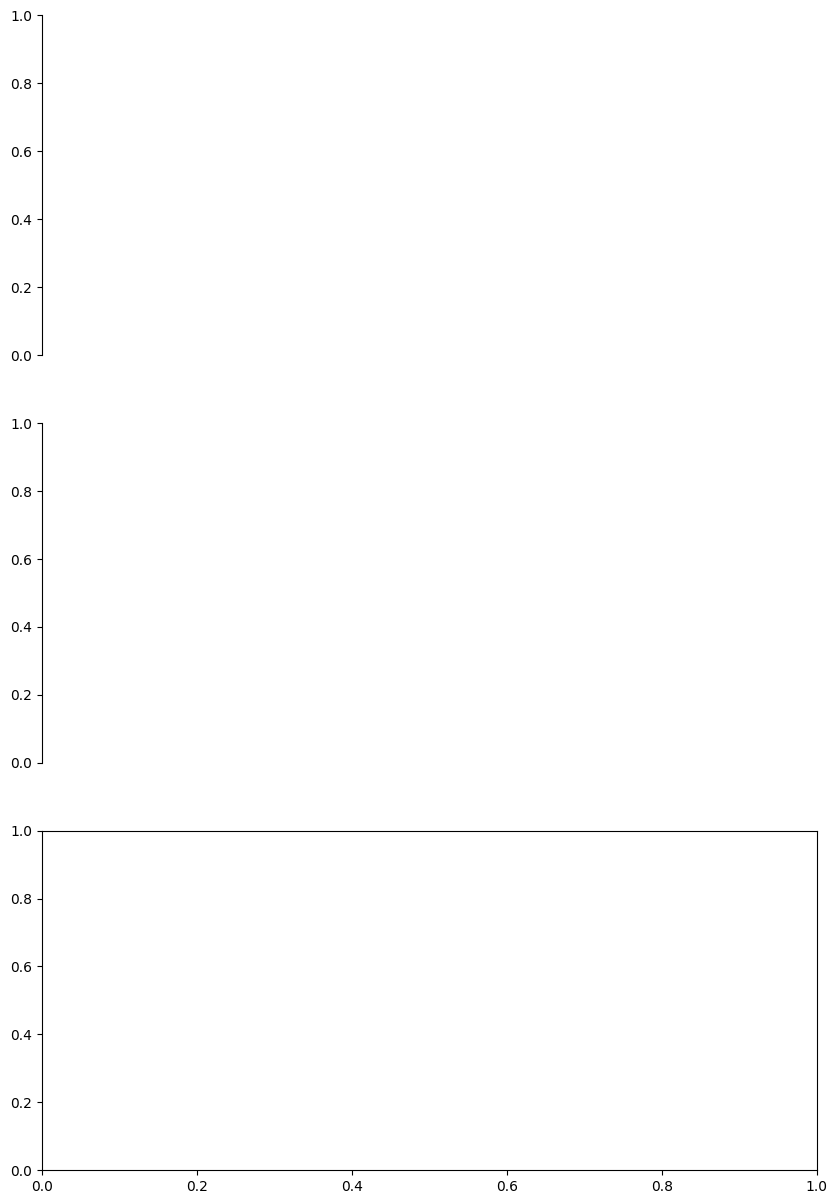

In [10]:
figs, axes = plt.subplots(3, 1, figsize=(10,15))
for qualified_pair in glob(pjoin('data', 'PMSE', '*.csv')):
    pairs = pd.read_csv(qualified_pair)
    
    for ind, row in pairs.iterrows():
        pfc = row['pfc']
        str = row['str']
        session = row[1]

        pfc_path = pjoin('data', 'spike_times', session, f'{pfc}.npy')
        str_path = pjoin('data', 'spike_times', session, f'{str}.npy')

        pfc_data = np.load(pfc_path, allow_pickle=True)
        str_data = np.load(str_path, allow_pickle=True)

        behaviour_path = pjoin('data', 'behaviour_data', 'csv', 'task_info', f'{session}.csv')
        task_info = pd.read_csv(behaviour_path)

        cue_times = task_info['cue_time']

        raster(spikes=str_data, cue_times=cue_times, ax=axes[0], name=str)
        raster(spikes=pfc_data, cue_times=cue_times, ax=axes[1], name=pfc)
        

        data = np.load(pjoin('data', 'PMSE', session, f"{str}_{pfc}.npy"))
        mean, std, bins = data

        relative_times = get_relative_times(pfc_data, str_data)

        window = [0.0005, 0.004]
        left_ind = int((window[0] + LEFT) * FREQ)
        right_ind = int((window[1] + LEFT) * FREQ)
        
        # Method 4
        window = [0.0005, 0.004]
        left_ind = int((window[0] + LEFT) * FREQ)
        right_ind = int((window[1] + LEFT) * FREQ)
        
        real_peaks = []
        bins_in_window = bins[left_ind: right_ind]
        heights = std[left_ind: right_ind]
        peaks, properties = find_peaks(bins_in_window, height=heights)
        if len(peaks) > 0:
            for peak in peaks:
                if bins[peak + left_ind] > mean[peak + left_ind] + 10:
                    # check full width at half maximum
                    left, right, counts = FWHM(peak + left_ind, bins)
                    if (right + left + 1) * (1/FREQ) <= 0.003:
                        real_peaks.append(peak + left_ind)
                    
        if len(real_peaks) > 0:
            sns.histplot(x=relative_times, bins=np.arange(start=-LEFT, stop=RIGHT + 1/(2*FREQ), step=1/FREQ), ax=axes[2])
            sns.lineplot(x=np.arange(start=-LEFT+1/(2* FREQ), stop=RIGHT, step=1/FREQ), y=bins, ax=axes[2])
            sns.lineplot(x=np.arange(start=-LEFT+1/(2* FREQ), stop=RIGHT, step=1/FREQ), y=mean, ax=axes[2])
            sns.lineplot(x=np.arange(start=-LEFT+1/(2* FREQ), stop=RIGHT, step=1/FREQ), y=std, ax=axes[2])
            for peak in real_peaks:
                axes[2].plot(-LEFT + 1/(2*FREQ) + peak * (1/FREQ), bins[peak], 'ro')

        axes[2].axvline(x=window[0])
        axes[2].axvline(x=window[1])
        axes[2].set_xlim([-0.01, 0.02])

        figs.savefig(pjoin('data', 'PMSE', 'qualified_stiched', f"{session}_{str}_{pfc}.png"), dpi=400)

        axes[0].clear()
        axes[1].clear()
        axes[2].clear()
    
        